In [106]:
import yfinance as yf
import pandas as pandas
from datetime import datetime, timedelta
import numpy as numpy
from scipy.optimize import minimize

In [107]:
tickers = ['SPY', 'GLD','BND','QQQ', 'VTI', 'NVDA','AMZN']
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)


In [108]:
adj_close = pandas.DataFrame()

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True) # Using adjusted close to include dividends and stock splits in model

[*********************100%***********************]  7 of 7 completed


In [109]:
adj_close = data['Close']

In [110]:
adj_close

Ticker,AMZN,BND,GLD,NVDA,QQQ,SPY,VTI
Date,,,,,,,
2015-01-05,15.109500,62.959351,115.800003,0.474983,93.867722,169.475876,87.635681
2015-01-06,14.764500,63.141644,117.120003,0.460582,92.609123,167.879654,86.777046
2015-01-07,14.921000,63.179638,116.430000,0.459382,93.802933,169.971603,87.812485
2015-01-08,15.023000,63.080879,115.940002,0.476663,95.598305,172.987747,89.361496
2015-01-09,14.846500,63.187206,117.260002,0.478583,94.969002,171.601486,88.620628
...,...,...,...,...,...,...,...
2024-12-24,229.050003,71.849998,241.440002,140.220001,529.960022,601.299988,297.119995
2024-12-26,227.050003,71.900002,243.070007,139.929993,529.599976,601.340027,297.290009
2024-12-27,223.750000,71.750000,241.399994,137.009995,522.559998,595.010010,294.070007


In [111]:
  # Calculating lognormal returns for each ticker
log_returns = numpy.log(adj_close/adj_close.shift(1))
log_returns

Ticker,AMZN,BND,GLD,NVDA,QQQ,SPY,VTI
Date,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,-0.023098,0.002891,0.011334,-0.030787,-0.013499,-0.009463,-0.009846
2015-01-07,0.010544,0.000602,-0.005909,-0.002609,0.012808,0.012384,0.011862
2015-01-08,0.006813,-0.001564,-0.004217,0.036927,0.018959,0.017589,0.017486
2015-01-09,-0.011818,0.001684,0.011321,0.004020,-0.006605,-0.008046,-0.008325
...,...,...,...,...,...,...,...
2024-12-24,0.017573,0.001435,0.001990,0.003930,0.013469,0.011054,0.010556
2024-12-26,-0.008770,0.000696,0.006728,-0.002070,-0.000680,0.000067,0.000572
2024-12-27,-0.014641,-0.002088,-0.006894,-0.021088,-0.013382,-0.010582,-0.010890


In [112]:
log_returns.isna().sum()

Ticker
AMZN    1
BND     1
GLD     1
NVDA    1
QQQ     1
SPY     1
VTI     1
dtype: int64

In [113]:
log_returns = log_returns.dropna()

In [114]:
log_returns.isna().sum()

Ticker
AMZN    0
BND     0
GLD     0
NVDA    0
QQQ     0
SPY     0
VTI     0
dtype: int64

Calculating Covariance Matrix

In [115]:
cov_matrix = log_returns.cov()*252

In [116]:
cov_matrix

Ticker,AMZN,BND,GLD,NVDA,QQQ,SPY,VTI
Ticker,,,,,,,
AMZN,0.106659,0.001893,0.002304,0.081624,0.053955,0.036412,0.036735
BND,0.001893,0.002977,0.002798,0.001897,0.001384,0.001065,0.001156
GLD,0.002304,0.002798,0.019939,0.001485,0.001773,0.001205,0.001312
NVDA,0.081624,0.001897,0.001485,0.232580,0.077887,0.054757,0.055904
QQQ,0.053955,0.001384,0.001773,0.077887,0.047857,0.035937,0.036483
SPY,0.036412,0.001065,0.001205,0.054757,0.035937,0.031233,0.031763
VTI,0.036735,0.001156,0.001312,0.055904,0.036483,0.031763,0.032567


Calculating portfolio standard deviation

In [117]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return numpy.sqrt(variance)

Calculating expected return

In [118]:
def expected_return(weights, log_returns):
    return numpy.sum(weights*log_returns.mean())*252

Calculating sharpe ratio

In [119]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    ret = expected_return(weights, log_returns)
    sd = standard_deviation(weights, cov_matrix)
    return (ret - risk_free_rate) / sd

Set the risk free rate

In [120]:
from fredapi import Fred
fred = Fred(api_key='107ae07a2fae8ae3ab8903c087fcf0f4')
ten_year_treasury = fred.get_series('GS10')/100

risk_free_rate = ten_year_treasury.iloc[-1]
risk_free_rate

0.0436

Minimising negative sharpe ratio (esssentially maximising sharpe ratio)

In [121]:
def negative_sharpe(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

Setting constraints and bounds

In [122]:
constraints = ({'type': 'eq', 'fun': lambda x: numpy.sum(x) - 1})
bounds = [(0,0.4) for i in range(len(tickers))]

Setting inital weights

In [123]:
initial_weights = numpy.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

Optimising weights to maximise sharpe ratio

In [124]:
optimised_sharpe = minimize(negative_sharpe, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

In [125]:
optimal_weights = optimised_sharpe.x

Visualising optimal portfolio

Optimal Portfolio Return: 30.95%
Optimal Portfolio Standard Deviation: 24.20%
Optimal Portfolio Sharpe Ratio: 1.10


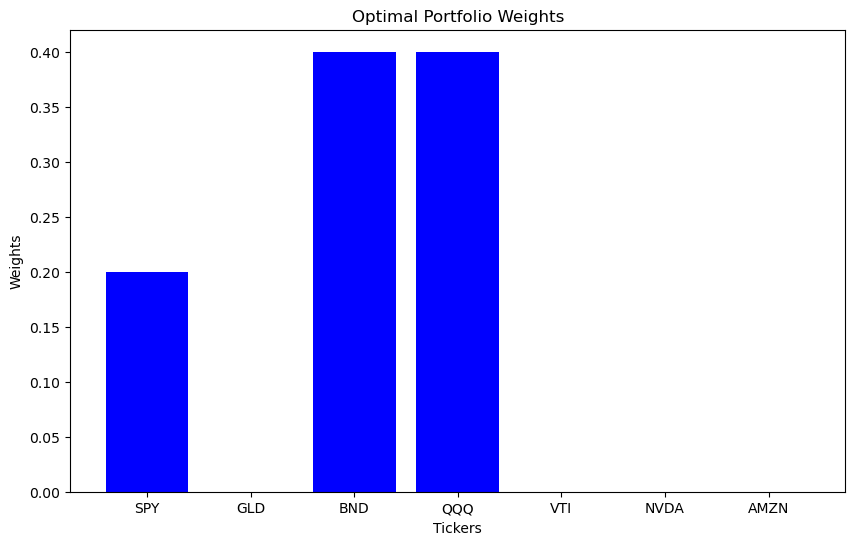

In [126]:
import matplotlib.pyplot as plt

# Calculate portfolio analytics
optimal_return = expected_return(optimal_weights, log_returns)
optimal_std_dev = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal Portfolio Return: {optimal_return:.2%}")
print(f"Optimal Portfolio Standard Deviation: {optimal_std_dev:.2%}")
print(f"Optimal Portfolio Sharpe Ratio: {optimal_sharpe_ratio:.2f}")

# Plot the final portfolio
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, color='blue')
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights')
plt.show()